<img src="../images/headers/nb_2.svg"  width="1080" height="220">

In this notebook, the data will be visualized and analyzed

# Import Modules and Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bokeh.io import output_notebook


from roaf import visualization

plt.style.use("dark_background")

In [2]:
df_by_person = pd.read_parquet("../data/processed/df_by_person.parquet")
df_by_accident = pd.read_parquet("../data/processed/df_by_accident.parquet")

# Setup of notebook parameters

In [3]:
PLOT_DIR = "../images/"
PLOT_FILE_FORMATS = ["png"]

# Daytime distribution of accidents

In [4]:
plot_df = pd.DataFrame(
    {
        "is_weekend": df_by_accident["is_weekend"],
        "time": df_by_accident["date"].apply(lambda x: int(x.strftime("%H%M"))),
    }
)

['../images/daytime_weekdays.png']

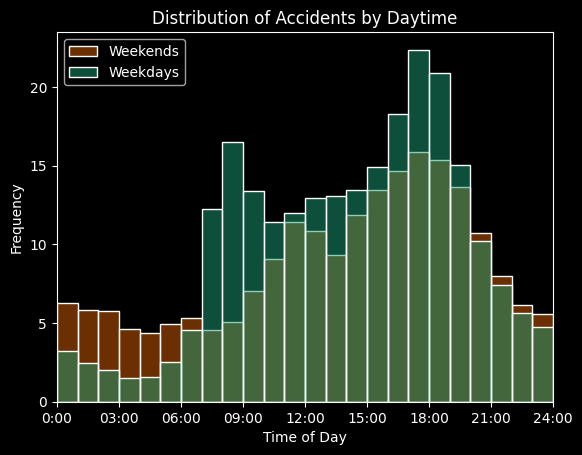

In [5]:
day_time_ticks = (0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400)
day_time_tick_labels = (
    "0:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
    "24:00",
)
fig = plt.figure()
plot_df = df_by_accident[["is_weekend", "hhmm"]].astype("int")
weights = plot_df["is_weekend"].apply(lambda x: 0.5 if x == 1 else 0.2)
sns.histplot(
    data=plot_df,
    x="hhmm",
    hue="is_weekend",
    weights=weights,
    stat="frequency",
    bins=24,
    binrange=(0, 2400),
    common_norm=False,
    palette="Dark2",
)
plt.xticks(ticks=day_time_ticks, labels=day_time_tick_labels)
plt.xlabel("Time of Day")
plt.xlim((0, 2400))
plt.legend(["Weekends", "Weekdays"])
plt.title("Distribution of Accidents by Daytime")

visualization.savefig(
    basename="daytime_weekdays", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
)

The plot shows the distribution of accidents during the day. Most accidents happen around 6 pm
both on weekends and during the week. Mon-Fri there is also a peak before 9 a.m. (when people
go to work). At the weekend, there are more accidents after midnight (when people return from
parties).

# Age, sex, and role in accident

['../images/age_sex_role.png']

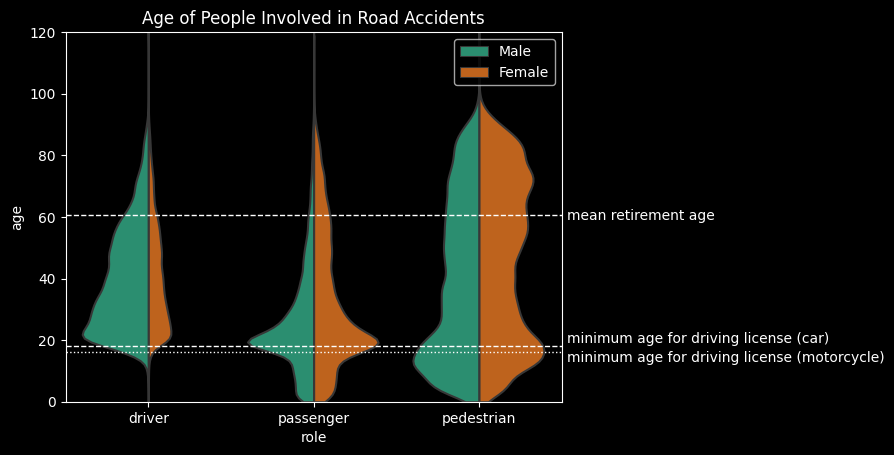

In [6]:
ax = sns.violinplot(
    data=df_by_person,
    x="role",
    y="age",
    hue="sex",
    bw=0.1,
    scale="count",
    split=True,
    palette="Dark2",
    inner=None,
    cut=0,
)
plt.title("Age of People Involved in Road Accidents")
plt.ylim((0, df_by_person["age"].max()))
ax.set_xticklabels(["driver", "passenger", "pedestrian"])


# Add some horizontal lines for important ages
def add_ageline(age, text, linestyle="--", y_offset=-1.5):
    """Plot a horizontal line for a specified age with annotation"""
    plt.axhline(y=age, linestyle=linestyle, linewidth=1)
    plt.annotate(
        text=text, xy=(1.01, age + y_offset), xycoords=("axes fraction", "data")
    )


# Minimum ages for drvinig license
add_ageline(age=18, text="minimum age for driving license (car)", y_offset=1)
add_ageline(
    age=16,
    text="minimum age for driving license (motorcycle)",
    linestyle="dotted",
    y_offset=-3,
)

# People stop working with 60.6 years, according to the
# OECD (https://www.oecd.org/fr/france/PAG2021-FRA.pdf)
add_ageline(age=60.6, text="mean retirement age")

ax.legend(handles=ax.legend_.legend_handles, labels=["Male", "Female"])

visualization.savefig(
    basename="age_sex_role", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
)

The plot shows a huge difference for the sex of drivers involved in accidents.
To interpret this figure correctly, one would need more information about the distribution of
drivers, as men might simply be more often the person who drives.

Another interesting observation is that at higher age, there are virtually no male passengers
involved. A possible explanation is, that men drive themselves while their wives are their
passengers.

I expected to see a greater effect of the retirement age.

It might be important for the understanding that a 'driver' can also simply drive a bike, which
explains the drivers under 16

# Geodata

In [7]:
output_notebook()
visualization.plot_geodata(
    df_by_accident,
    n_plot_max=10_000,
    figsize=int(500),
    return_html=False,
)

Loading BokehJS ...

In [8]:
plot_data = df_by_accident.sample(1_000)
m = visualization.plot_geo_markers(df=plot_data)
visualization.plot_geo_heatmap(df_by_accident, m=m)

The heatmap does not provide meaningful information at first glance:
One can see that there are more accidents in densly populated areas, but that is obviuos.
It gets interesting when zooming in. Then, it is possible to see the local hotspots for
accidents.

Unfortunately, plotting Folium markers is quite slow, and only a small number of accidents
are plotted on the map. The whole dataset was used for the heatmap, however.